<a href="https://colab.research.google.com/github/nilanahar/Binary_Classification_Using_Decision_Tree_Model/blob/main/869_ML_AI_A1_(4_2_1_1_3)_SimpleImputation_JamesStein_BoxCox_Xgboost_Optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import f1_score, make_scorer
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from category_encoders import JamesSteinEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import resample

# Load the dataset
url = "https://drive.google.com/uc?export=download&id=1eYCKuqJda4bpzXBVnqXylg0qQwvpUuum"
df = pd.read_csv(url)

# Separate majority and minority classes
df_majority = df[df['h1n1_vaccine'] == 0]
df_minority = df[df['h1n1_vaccine'] == 1]

# Calculate the desired number of samples for each class
n_minority = len(df_minority)
n_majority = int(n_minority * (3/2))  # Adjust the ratio here (3/2 = 60/40)

# Upsample majority class
df_majority_upsampled = resample(df_majority,
                                 replace=True,     # sample with replacement to duplicate data
                                 n_samples=n_majority,  # to match 60/40 ratio
                                 random_state=42)  # reproducible results

# Combine minority class with upsampled majority class
df_upsampled = pd.concat([df_minority, df_majority_upsampled])

# Display new class counts
print(df_upsampled['h1n1_vaccine'].value_counts(normalize=True))

# Check the shape of the new dataset
print(df_upsampled.shape)

df = df_upsampled

# Define target column
target_column = 'h1n1_vaccine'

# Function to generate summary of the dataset
def generate_summary(df):
    numerical_features_summary = df.describe().T
    unique_counts_num = df.select_dtypes(include=[np.number]).nunique()
    numerical_summary = numerical_features_summary[['count']].copy()
    numerical_summary['unique'] = unique_counts_num
    numerical_summary['nulls'] = df.select_dtypes(include=[np.number]).isnull().sum()
    numerical_summary['has_nulls'] = numerical_summary['nulls'] > 0
    numerical_summary = numerical_summary.reset_index()
    numerical_summary['type'] = 'numerical'

    categorical_features_summary = df.describe(include='object').T
    unique_counts_cat = df.select_dtypes(include=['object']).nunique()
    categorical_summary = categorical_features_summary[['count']].copy()
    categorical_summary['unique'] = unique_counts_cat
    categorical_summary['nulls'] = df.select_dtypes(include=['object']).isnull().sum()
    categorical_summary['has_nulls'] = categorical_summary['nulls'] > 0
    categorical_summary = categorical_summary.reset_index()
    categorical_summary['type'] = 'categorical'

    combined_summary = pd.concat([numerical_summary, categorical_summary], ignore_index=True)
    combined_summary = combined_summary.rename(columns={'index': 'features'})
    combined_summary.loc[combined_summary['features'] == target_column, 'type'] = 'target'
    return combined_summary

summary = generate_summary(df)

# Extract categorical and numerical features
categorical_features = summary.query('type == "categorical"')['features'].tolist()
numerical_features = summary.query("type == 'numerical' and features != 'h1n1_vaccine'")['features'].tolist()

# Custom transformer for shifting data
class ShiftTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.shift_values = {}
        X_array = X if isinstance(X, np.ndarray) else X.values
        for col in range(X_array.shape[1]):
            min_value = np.min(X_array[:, col])
            if min_value <= 0:
                self.shift_values[col] = -min_value + 1
            else:
                self.shift_values[col] = 0
        return self

    def transform(self, X):
        X_array = X if isinstance(X, np.ndarray) else X.values
        X_transformed = X_array.copy()
        for col, shift_value in self.shift_values.items():
            X_transformed[:, col] += shift_value
        return X_transformed

# Split into features and target variable
X = df.drop(target_column, axis=1)
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26, stratify=y)

# Define preprocessing pipelines
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('james_stein_encoder', JamesSteinEncoder()),
    ('shift', ShiftTransformer()),  # Apply shifting to categorical features as well
    ('scaler', PowerTransformer(method='box-cox'))
])

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('shift', ShiftTransformer()),
    ('scaler', PowerTransformer(method='box-cox'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Define the objective function for Optuna
def objective(trial):
    # Define the XGBoost model
    xgb_model = XGBClassifier(
        n_estimators=trial.suggest_int('classifier__n_estimators', 400, 900),
        max_depth=trial.suggest_int('classifier__max_depth', 7, 15),
        learning_rate=trial.suggest_float('classifier__learning_rate', 0.01, 0.05, log=True),
        subsample=trial.suggest_float('classifier__subsample', 0.4, 0.8, log=True),
        colsample_bytree=trial.suggest_float('classifier__colsample_bytree', 0.4, 0.8, log=True),
        reg_alpha = trial.suggest_float('classifier__reg_alpha', 0.01, 0.1, log=True),
        reg_lambda = trial.suggest_float('classifier__reg_lambda', 0.01, 0.1, log=True),
        random_state=26,
        use_label_encoder=False,
        eval_metric='logloss'
    )

    # Define the full pipeline with preprocessing, feature selection, and model
    full_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(mutual_info_classif, k=trial.suggest_int('feature_selection__k', 15, 25))),
        ('classifier', xgb_model)
    ])

    # Perform cross-validation
    f1_macro_scorer = make_scorer(f1_score, average='macro')
    scores = cross_val_score(full_pipeline, X_train, y_train, cv=5, scoring=f1_macro_scorer)

    return np.mean(scores)

# Create a study and optimize the objective function with pruning
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=7), pruner=MedianPruner())
study.optimize(objective, n_trials=15, n_jobs=-1)

# Print the best parameters and best score
print(f"Best parameters found: {study.best_params}")
print(f"Best cross-validation F1 score: {study.best_value}")

# Refit the model on the entire training dataset with the best parameters
best_params = study.best_params
best_model = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(mutual_info_classif, k=best_params['feature_selection__k'])),
    ('classifier', XGBClassifier(
        n_estimators=best_params['classifier__n_estimators'],
        max_depth=best_params['classifier__max_depth'],
        learning_rate=best_params['classifier__learning_rate'],
        subsample=best_params['classifier__subsample'],
        colsample_bytree=best_params['classifier__colsample_bytree'],
        reg_alpha=best_params['classifier__reg_alpha'],
        reg_lambda=best_params['classifier__reg_lambda'],
        random_state=26,
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])

best_model.fit(X_train, y_train)

# Evaluate the final model on the test set
y_pred_test = best_model.predict(X_test)
test_f1_score = f1_score(y_test, y_pred_test, average='macro')

# Print the test (leaderboard) score
print("The test F1 score with the final tuned XGBoost model is:")
print(test_f1_score)

# PREDICTIONS ON COMPETITION DATA

# Load the competition dataset
X_comp = pd.read_csv("https://drive.google.com/uc?export=download&id=1SmFBoNh7segI1Ky92mfeIe6TpscclMwQ")

# Apply preprocessing steps to the competition data using the fitted pipeline
X_comp_transformed = best_model.named_steps['preprocessor'].transform(X_comp)

# Ensure the same number of features are selected for the competition data
X_comp_scaled = best_model.named_steps['feature_selection'].transform(X_comp_transformed)

# Use your model to make predictions on the competition data
pred_comp = best_model.named_steps['classifier'].predict(X_comp_scaled)

my_submission = pd.DataFrame({'predicted': pred_comp})

# Print a peek at the results (as a sanity check)
print(my_submission.head(10))


[I 2024-06-04 17:14:12,121] A new study created in memory with name: no-name-c245c4a1-674b-4ebe-ab28-b823a6e98f91


0    0.6
1    0.4
Name: h1n1_vaccine, dtype: float64
(11360, 36)


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/lib/pyt

[I 2024-06-04 17:15:39,576] Trial 5 finished with value: 0.7928508782177737 and parameters: {'classifier__n_estimators': 729, 'classifier__max_depth': 15, 'classifier__learning_rate': 0.024872465210156104, 'classifier__subsample': 0.50007929562486, 'classifier__colsample_bytree': 0.41557725290562275, 'classifier__reg_alpha': 0.05081771383292861, 'classifier__reg_lambda': 0.02043352935879733, 'feature_selection__k': 22}. Best is trial 5 with value: 0.7928508782177737.
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
[I 2024-06-04 17:16:02,308] Trial 7 finished with value: 0.792772723470892 and parameters: {'classifier__n_estimators': 793, 'classifier__max_depth': 14, 'classifier__learning_rate': 0.02719

Best parameters found: {'classifier__n_estimators': 671, 'classifier__max_depth': 11, 'classifier__learning_rate': 0.011067016906132286, 'classifier__subsample': 0.5371850239414573, 'classifier__colsample_bytree': 0.5092655311690257, 'classifier__reg_alpha': 0.05360318622645465, 'classifier__reg_lambda': 0.0975160291136743, 'feature_selection__k': 25}
Best cross-validation F1 score: 0.7947860203820742
The test F1 score with the final tuned XGBoost model is:
0.8105946507507051
   predicted
0          0
1          1
2          0
3          0
4          0
5          1
6          0
7          0
8          0
9          1


In [ ]:
import os as os
# Specify the directory and filename
directory = '/Users/nilanahar/Downloads'  # Replace with your directory path
filename = 'my_submission_final_moments_(2).csv'

# Ensure the directory exists
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the submission to CSV
my_submission.to_csv(os.path.join(directory, filename), index=False)


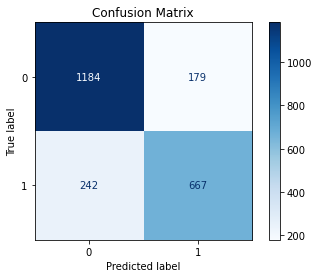

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt

# Predict probabilities on the test data
y_probs = best_model.predict_proba(X_test)[:, 1]

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)
average_precision = average_precision_score(y_test, y_probs)

# Predict on the test data
y_pred = best_model.predict(X_test)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual No', 'Actual Yes'], columns=['Predicted No', 'Predicted Yes'])
f1_test = f1_score(y_test, y_pred)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


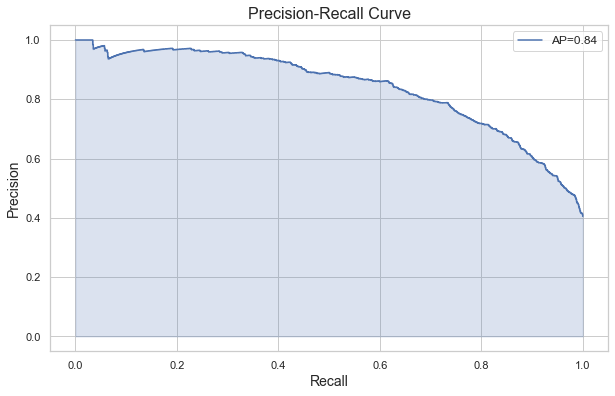

In [ ]:
## PR CURVE ##
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=recall, y=precision, drawstyle='steps-post', color='b', label=f'AP={average_precision:0.2f}')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.show()
